# Baseline Modelling, Kaggle Bias Data Set

## Introduction
To begin a baseline model will be developed only using text features.  Other features may be incorporated to identify toxicity in further iterations. The data sets train.csv and test_public_expanded.csv are used. A linear regression will be done to predict toxicity as a float, and logistic regression will be done with toxicity as a binary target. Different iterations of logistic regression will be done to gain insight on text processing and vectorization. 

## Methodology
This notebook will focus on a 20% sample of the data taken, ensuring the same distribution of target variable as the original dataset. The target distribution is assessed and data set is found to be imbalanced, the distirubtion of target will be left as is in this notebook, however methods for dealing will the class imbalance may be explored further. This notebook follows the following general workflow: 
- Clean comment_text
- Create Binary target column
- Process text:
  - tokenization and vectorization techniques
        - Count Vectorizer, TF-IDF
        - Tokenizer function
- Base Linear Regression
- Base Logistic Regression and Iterations
  - Process text in different ways
  - Perfrom Logistic Regression using gridsearch , optimize for C, regularization parameter.

As logistic regression is a baseline model, no further optimization will be done. The use of logistic regression here is to get a benchmark for predicting toxicity as well as to gain insight into text preprocessing methods. 

## Data Dictionary

### Train DF 
| Column Name   | Description                                      |
|---------------|--------------------------------------------------|
| comment_text  | Text of the comment                              |
| target        | Predicted toxicity score (fraction of annotators who found the comment toxic) |                       
| binary_target | Binary indicator of toxicity (toxic or non-toxic)|

### Test DF
| Column Name   | Description                                      |
|---------------|--------------------------------------------------|
| comment_text  | Text of the comment                              |
| toxicity      | Predicted toxicity score (fraction of annotators who found the comment toxic) |
| binary_target | Binary indicator of toxicity (toxic or non-toxic)|



In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
train = pd.read_csv('../data/kaggle_bias/train.csv')

In [3]:
test = pd.read_csv('../data/kaggle_bias/test_public_expanded.csv')

In [4]:
train.shape

(1804874, 45)

In [5]:
test.shape

(97320, 45)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97320 entries, 0 to 97319
Data columns (total 45 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   97320 non-null  int64  
 1   comment_text                         97320 non-null  object 
 2   created_date                         97320 non-null  object 
 3   publication_id                       97320 non-null  int64  
 4   parent_id                            54354 non-null  float64
 5   article_id                           97320 non-null  int64  
 6   rating                               97320 non-null  object 
 7   funny                                97320 non-null  int64  
 8   wow                                  97320 non-null  int64  
 9   sad                                  97320 non-null  int64  
 10  likes                                97320 non-null  int64  
 11  disagree                    

In [8]:
train.isnull().sum()

id                                           0
target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [9]:
test.isnull().sum()

id                                         0
comment_text                               0
created_date                               0
publication_id                             0
parent_id                              42966
article_id                                 0
rating                                     0
funny                                      0
wow                                        0
sad                                        0
likes                                      0
disagree                                   0
toxicity                                   0
severe_toxicity                            0
obscene                                    0
sexual_explicit                            0
identity_attack                            0
insult                                     0
threat                                     0
identity_annotator_count                   0
toxicity_annotator_count                   0
male                                   76027
female    

In [10]:
#nulls in text
test.dropna(subset=['comment_text'], inplace=True)
train.dropna(subset=['comment_text'], inplace=True)

### Distribution of Target Variable

In [11]:
train['target'].value_counts()

target
0.000000    1264761
0.166667     138501
0.200000     107492
0.300000      59098
0.400000      50013
             ...   
0.026684          1
0.924561          1
0.007458          1
0.145161          1
0.870088          1
Name: count, Length: 2913, dtype: int64

In [12]:
test['toxicity'].value_counts()

toxicity
0.000000    68725
0.166667     7375
0.200000     5720
0.300000     3071
0.400000     2674
            ...  
0.305556        1
0.372549        1
0.881579        1
0.711538        1
0.835319        1
Name: count, Length: 1091, dtype: int64

In [13]:
#Find proportions of y > 0 in train and test,.mean() applied to boolean val will give proportion of True vals
train_percent_tox = (train['target']>0).mean()*100
test_percent_tox = (test['toxicity']>0).mean()*100

print("Percentage of 'target' greater than 0 in train set:", train_percent_tox)
print("Percentage of 'toxicity' greater than 0 in test set:", test_percent_tox)

Percentage of 'target' greater than 0 in train set: 29.92513038327947
Percentage of 'toxicity' greater than 0 in test set: 29.38244965063707


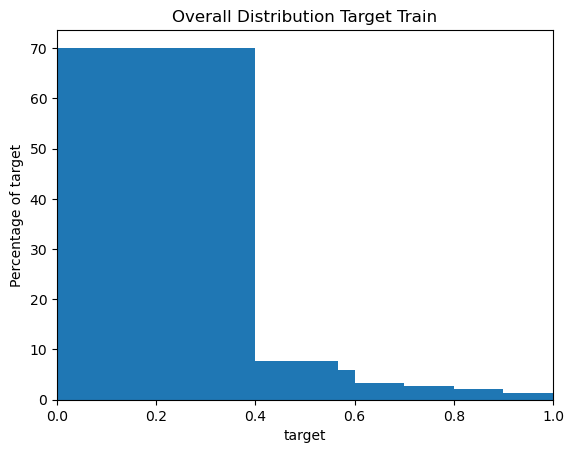

In [14]:
class_distribution = train['target'].value_counts().to_dict()
overall_count = train['target'].value_counts(normalize=True)*100

plt.bar(overall_count.index, overall_count.values)
plt.title('Overall Distribution Target Train')
plt.xlabel('target')
plt.ylabel('Percentage of target') 
plt.xlim(0, max(overall_count.index))

plt.show()

There is a imbalance of comments labeled as toxic, and comments with a 0 value for toxicity. About 70% of the data is where y <= 0.4. This may possibly be addressed with weighted matrix, or methods of resampling. 

In [15]:
train['target'].mean()

0.10301746429481355

In [16]:
test['toxicity'].mean()

0.10130833537642256

In [17]:
#create binary column for baseline logistic regression: 
train['binary_target'] = (train['target']>0.5).astype(int)
test['binary_target'] = (test['toxicity']>0.5).astype(int)

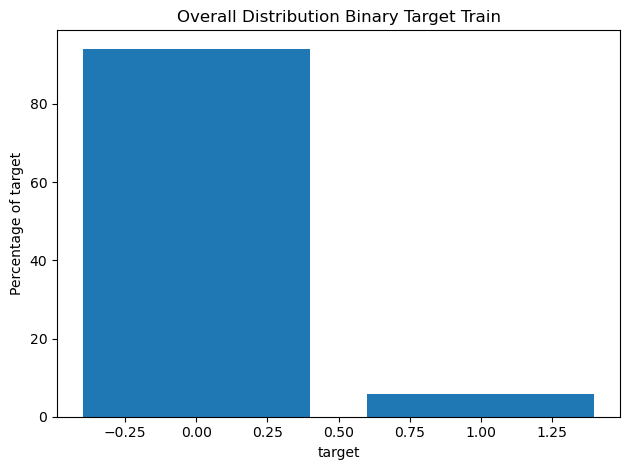

The absolute class distribution is: {0: 1698433, 1: 106438}
Count for score 1: 106438
Count for score 0: 1698433

The relative (%) class distribution is: 
binary_target
0    94.102736
1     5.897264
Name: proportion, dtype: float64


In [18]:
#distribution of target in train and test sets: 
class_distribution = train['binary_target'].value_counts().to_dict()
overall_count = train['binary_target'].value_counts(normalize=True)*100

plt.bar(overall_count.index, overall_count.values)
plt.title('Overall Distribution Binary Target Train')
plt.xlabel('target')
plt.ylabel('Percentage of target') 

plt.tight_layout()
plt.show()
print(f'The absolute class distribution is:', class_distribution)
print(f'Count for score 1:', class_distribution[1])
print(f'Count for score 0:', class_distribution[0])
print('\nThe relative (%) class distribution is:', f'\n{overall_count}')

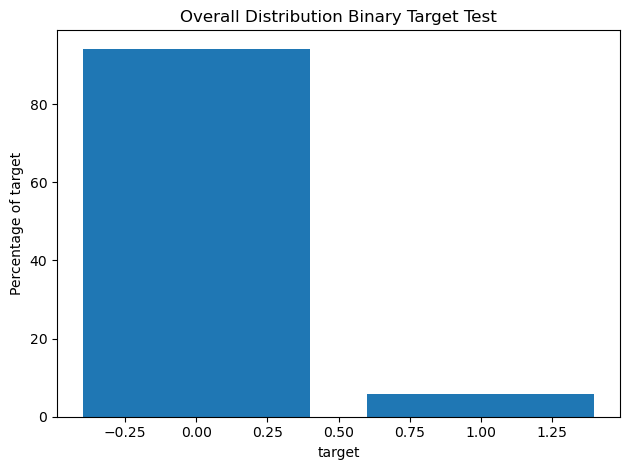

The absolute class distribution is: {0: 91671, 1: 5649}
Count for score 1: 5649
Count for score 0: 91671

The relative (%) class distribution is: 
binary_target
0    94.195438
1     5.804562
Name: proportion, dtype: float64


In [19]:
class_distribution = test['binary_target'].value_counts().to_dict()
overall_count = test['binary_target'].value_counts(normalize=True)*100

plt.bar(overall_count.index, overall_count.values)
plt.title('Overall Distribution Binary Target Test')
plt.xlabel('target')
plt.ylabel('Percentage of target') 

plt.tight_layout()
plt.show()
print(f'The absolute class distribution is:', class_distribution)
print(f'Count for score 1:', class_distribution[1])
print(f'Count for score 0:', class_distribution[0])
print('\nThe relative (%) class distribution is:', f'\n{overall_count}')

## Vectorization of Text: CountVectorizer

In [20]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
import time

**Define tokenizer as function**

In [29]:
def my_tokenizer(document, lemmatization=False, stemming=False, custom_stopwords=None, include_stopwords=None):
    '''
    Function for use in CountVectorizer that tokenizes the document
    '''
    # initialize stop words set within function, changes to stop words stay within function.
    stop_words = set(stopwords.words('english'))

    # remove punctuation and split on spaces, remove /n
    translator = str.maketrans("", "", string.punctuation)
    document = document.translate(translator).replace('\n', ' ')
    tokenized_document = document.lower().split()

    # handle custom stopwords
    #use .discard() to remove certain words from stop words list
    if custom_stopwords is not None:
        # remove custom stop words from stop_words set
        for word_to_remove in custom_stopwords:
            stop_words.discard(word_to_remove)
            
    # include certain words if specified
    # use .update() to add a word to the stop words list
    if include_stopwords is not None:
        stop_words.update(include_stopwords)

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word not in stop_words]

    if stemming:
        stemmed_tokens_list = [PorterStemmer().stem(word) for word in tokenized_document]
        return stemmed_tokens_list

    if lemmatization:
        lemmatized_tokens_list = [WordNetLemmatizer().lemmatize(word) for word in tokenized_document]
        return lemmatized_tokens_list
        
    return tokenized_document


**Baseline Vectorization** 

To begin no stemming or lemmatization will be performed, stop words will be removed as well as punctuation. A sample of the train set will be used for computational efficiency. The sample will be a random 20% sample with same distribution as original data set. 
- Min_df = 10 (features must appear a min of 10 times)
- Max_features = 3000 (top 3000 features by term frequency)

In [22]:
#take a sample from the train data set, take stratified sample to maintain distribution. 
sampled_train = train.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.2))


In [23]:
sampled_train.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,binary_target
1429172,5866039,0.0,Bellevue is lucky to have a candidate like Ste...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,2,0,0.0,0,4,0
151655,427638,0.0,"And where do you extract your news from, roldrik?",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,0,0,0.0,0,4,0


In [24]:
#put tokenizer params into dictionary 
tokenizer_params_default= {'lemmatization':False,
                           'stemming':False,
                           'custom_stopwords':None,
                           'include_stopwords':None}

In [25]:
#check data type of comment text
print(train['comment_text'].dtype)
print(test['comment_text'].dtype)

object
object


In [26]:
#Define X_train and X_test for vectorization
X_train = sampled_train['comment_text']
X_test = test['comment_text']

In [85]:
#instantiate count vectorizer
vectorize_text = CountVectorizer(tokenizer= lambda x:my_tokenizer(x,**tokenizer_params_default),
                                             max_features =3000,
                                             min_df =10
                                            )

In [86]:
#fit and transform X_train, use .fit_transform() method
start_time = time.time()  #start timer

X_train_transformed = vectorize_text.fit_transform(X_train)

end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 


Vectorization took 20.68 seconds


In [87]:
start_time = time.time()  #start timer

X_test_transformed = vectorize_text.transform(X_test)

end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 


Vectorization took 5.23 seconds


As Vectorization of this sample size and max features took 20 Seconds Vectorization will be done in a pipeline with different amounts of max features to optimize Linear and Logistic Regression for first iteration. A second iteration may be done on a larger sample size of data depending on computational time. 

## Logistic and Linear Regression (Baseline Models)

In [109]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [134]:
results_ln_list =[]

**X_train, X_test, y_train, y_test**

In [82]:
#X_train, X_test defined above in vectorizer
#define y_train and y_test
y_train = sampled_train['target']
y_test= test['toxicity']

y_train_log = sampled_train['binary_target']
y_test_log = test['binary_target']

### Linear Regression

In [101]:
#Use LSA to reduce dimensionality
lsa = TruncatedSVD(n_components=300)
X_train_lsa = lsa.fit_transform(X_train_transformed)
X_test_lsa = lsa.transform(X_test_transformed)

In [102]:
#get feature names out
feature_names = vectorize_text.get_feature_names_out()

#create mapping of feature names
component_mapping = {}
for i, component in enumerate(lsa.components_):
    top_words_idx = component.argsort()[:-6:-1] #get index of top 5 words
    top_words = [feature_names[idx]for idx in top_words_idx]
    component_mapping[i]= top_words
#print mapping
for component, words in component_mapping.items():
    print(f'Component{component}: {", ".join(words)}')

Component0: people, would, one, like, dont
Component1: would, trump, us, president, one
Component2: trump, people, president, us, obama
Component3: would, people, trump, president, white
Component4: us, tax, government, people, state
Component5: one, us, people, would, many
Component6: tax, one, trump, state, money
Component7: dont, get, think, know, want
Component8: dont, tax, one, us, income
Component9: get, one, us, would, like
Component10: state, government, oil, right, alaska
Component11: time, years, state, oil, dont
Component12: time, right, tax, good, think
Component13: think, good, state, tax, oil
Component14: right, know, tax, even, many
Component15: years, good, know, even, year
Component16: good, many, know, money, make
Component17: know, even, money, think, much
Component18: know, government, good, years, get
Component19: right, money, know, many, years
Component20: oil, canada, gas, alaska, see
Component21: even, money, right, good, many
Component22: need, care, canada, h

In [97]:
#Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_lsa, y_train)

LinearRegression()

In [104]:
y_pred = lr_model.predict(X_test_lsa)

In [110]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared}')

Mean Squared Error: 0.03676540641737104
Mean Absolute Error: 0.13655003356345996
R-squared: 0.04488625083672848


In [135]:
#store results: 
result_linreg1 ={
    'Identifier': 'lin_reg1',
    'Vectorization': 'CountVectorizer',
    'n_grams' : 'None',
    'lemmatization':False,
    'stemming':False,
    'custom_stopwords':None,
    'include_stopwords':None,
    'MSE': mse,
    'MAD': mae,
    'R_squared': r_squared
}
results_ln_list.append(result_linreg1)

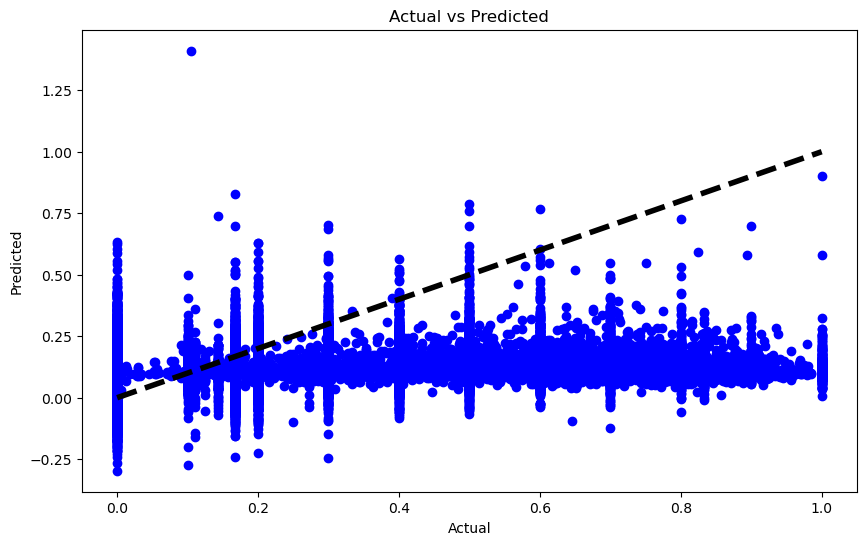

In [106]:
# Plotting the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In looking at plot of predictions vs. actual values it appears that the predicted values are not close to actual values as they points are not lying along the diagonal. Linear Regression shows a low R squared value and possible interpretation is that the model is not capturing relationships between text and toxicity rating (fraction of annotators that labeled comment as toxic). The use of n-grams as seen in notebook; Preprocessing_and_Tokenization_Arman did improve the mse by 0.01 and this may be explored further. The overall poor performance of linear regression model could be due to non liear relationships between the text and toxicity. Other ways of tokenization and vectorization may be explored, as well as the use of other models that are more adept at capturing non linear patterns. 

### Logistic Regression

In [141]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score


Logistic Regression will be done using: 
- solver: 'lbfgs'
- sample size: same sample as linear regression
- Target: binary_target

The Logistic Regression will be evaluated based on F1 score an balance of precision and Recall,
a perfect F1 score is 1. 
- Precision: This is the proportion of correctly predicted positive observations (true positives) out of all positive predictions (true positives + false positives). A higher precision indicates fewer false positives.
- Recall: This is the proportion of correctly predicted positive observations (true positives) out of all actual positives (true positives + false negatives). A higher recall indicates fewer false negatives.

Different tokenization and vectorization techniques may be explored. The Logistic Regression will serve as a basline model and provide insight into the feature relationship with toxicity. 

In [136]:
results_list =[]

In [197]:
#Use function for grid search
def run_grid_search(X_train, y_train, param_grid, pipeline, scoring_metric, identifier,
                   n_grams='None', vectorization= 'None', max_features= 'None', tokenizer_params= 'default'):
    """
    Run a grid search with the specified parameters.

    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - param_grid: Parameter grid for the grid search
    - pipeline: pipeline object
    - scoring_metric: Scikit-learn scoring metric
    - identifier: Identifier for iteration of Gridsearch'
    - n_grams: N-gram range used for vectorization (default=None)
    - vectorization: Vectorization technique used (default=None)
    - tokenizer_params: Additional parameters used in the tokenizer (default=None)


    Returns:
    - grid_search: Fitted GridSearchCV object 
    -resluts of cross validation in terms of best params, best score (validation set)
    - time it took to run GridSearch
    """
    #initiate timer module
    start_time = time.time()
   
    # Set up the scoring metric
    scoring =make_scorer(f1_score)

    # Instantiate GridSearchCV with 5-fold cross-validation, n_jobs=3, and specified scoring metric
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, n_jobs=3)

    # Fit and run grid search
    grid_search.fit(X_train, y_train)

    #end timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Calculate accuracy
    y_pred = grid_search.best_estimator_.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    
     # Store the results (hyperparameters and scores)
    results_list.append({
        'identifier': identifier,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'elapsed_time': elapsed_time,
        'n_grams': n_grams,
        'max_features': max_features,
        'vectorization': vectorization,
        'tokenizer_params': tokenizer_params
    })
    
    # Print the best parameters with the identifier
    print(f"Best Parameters for {identifier}: {grid_search.best_params_}")

    # Print the best score on the validation sets, 
    #.best_score_ is attribute of GridSearch CV that accesses best validation score(score specified in GS)
    print(f"Best {scoring_metric} Score for {identifier}: {grid_search.best_score_}")
    # Print the accuracy
    print(f"Accuracy for {identifier}: {accuracy}")
    # Print the elapsed time
    print(f"Elapsed Time for {identifier}: {elapsed_time} seconds")

    return grid_search

In [142]:
def evaluate_model(model, X_test, y_test):
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print the metrics
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    
    # Return the metrics
    return accuracy, precision, recall, f1

In [151]:
def plot_coefficients(model, feature_names, top_features=20):
    lr_model = model.named_steps['lr']
    coef = lr_model.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.xlabel('Feature')
    plt.ylabel('Coefficient Value')
    plt.title('Top 20 Coefficients and Features')
    plt.show()

In [131]:
#baseline log
pipeline_log_base = Pipeline([
    ('lr', LogisticRegression(max_iter=1000))
])


**Log Reg 1: Identifier: Log_Reg1**
- 'lemmatization':False,
- 'stemming':False,
- 'custom_stopwords':None,
- 'include_stopwords':None
- 'n_grams': None
- 'Vectorization': 'CountVectorizer'

In [129]:
#param grid, optimize for C-> regularization
param_grid_log = {
    'lr__C': [0.1, 1, 10]  
}

In [185]:
scoring_metric = 'F1 Score'
results_logreg1= run_grid_search(X_train_transformed, y_train_log, param_grid_log, pipeline_log_base, 
                                 scoring_metric, 'Log_Reg1', n_grams='None', vectorization= 'CountVectorizer', 
                                 tokenizer_params= 'default')

Best Parameters for Log_Reg1: {'lr__C': 10}
Best F1 Score Score for Log_Reg1: 0.4048247641834425
Accuracy for Log_Reg1: 0.9551872995100907
Elapsed Time for Log_Reg1: 13.5265531539917 seconds


In [144]:
#predict and Evaluate:
log_reg1_model = results_logreg1.best_estimator_
evaluate_model(log_reg1_model, X_test_transformed, y_test_log)

Accuracy: 0.9530312371557748
Precision: 0.7110415035238841
Recall: 0.32147282704903524
F1 Score: 0.44276484213092776


(0.9530312371557748,
 0.7110415035238841,
 0.32147282704903524,
 0.44276484213092776)

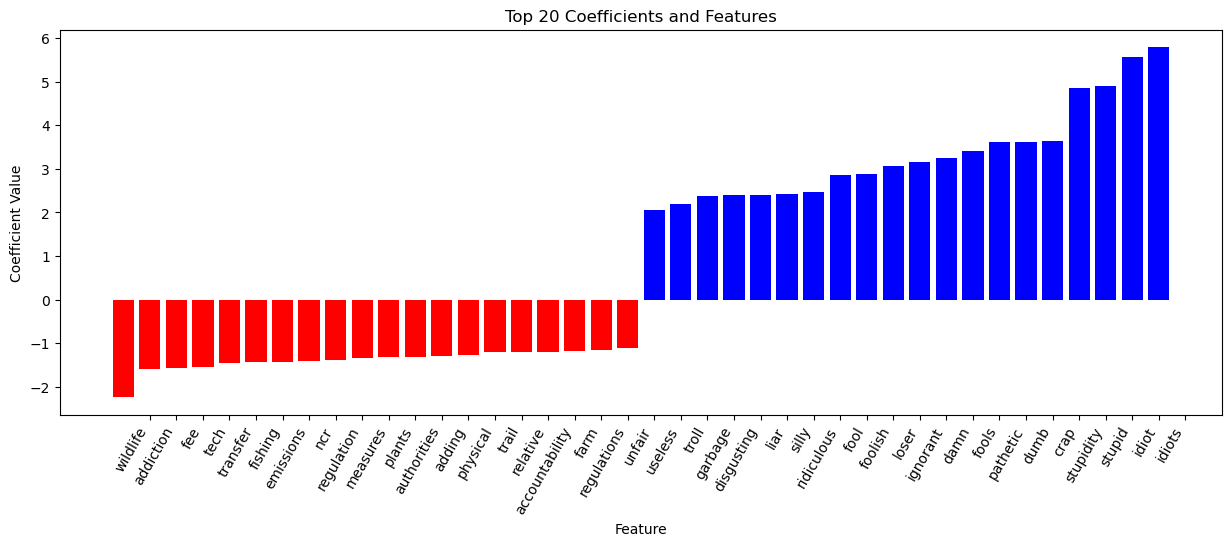

In [153]:
#plot coeffs, with features names, get feature names from vectorizer
#feature_names = vectorizer_text.get_feature_names() -> defined earlier
plot_coefficients(log_reg1_model, feature_names)

Words with negative coefficients, indicating a lower likeliehood of comment being toxic are indicitative of contexts or topics that are less likely to be toxic. These words might be associated with more formal or structured discussions, that are less likely to involve toxic language. In general these words are predominantly nouns, indicating specific concepts or entitites. Words with positive coefficients, show an increased likeliehood of toxicity in comment. These words appear to be insulting, derogatory and negative in context. It was seen in EDA that comments labeled as insulting had a higher co occurence with toxicity. Comments labeled as insulting also show a positive correlation with toxicity. In general these words also appear adjectival in nature and seem to describe negative attributes. This aligns with adjectives commonly being used to express sentiment while nouns (seen with positive coefficients) may not inherently carry sentiment such as toxicity.  

**Log Reg 2, n-grams: Identifier: Log_reg2**

N-grams will be used, and logistic regression assessed, features and coeffs will be evaluated. 
- 'lemmatization':False,
- 'stemming':False,
- 'custom_stopwords':None,
- 'include_stopwords':None
- 'n_grams': '(1,2)'
- 'Vectorization': 'CountVectorizer'

In [164]:
#instantiate count vectorizer
vectorizer_ngrams = CountVectorizer(tokenizer= lambda x:my_tokenizer(x,**tokenizer_params_default),
                                             max_features =3000,
                                             min_df =10,
                                             ngram_range =(1,2)
                                            )

In [165]:
#fit and transform X_train, use .fit_transform() method
start_time = time.time()  #start timer

X_train_transformed_n = vectorizer_ngrams.fit_transform(X_train)

end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 


Vectorization took 35.70 seconds


In [166]:
start_time = time.time()  #start timer

X_test_transformed_n = vectorizer_ngrams.transform(X_test)

end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 


Vectorization took 5.98 seconds


In [186]:
#Log Reg, use baseline pipeline, and same param grid 
scoring_metric = 'F1 Score'
results_logreg2= run_grid_search(X_train_transformed_n, y_train_log, param_grid_log, pipeline_log_base, 
                                 scoring_metric, 'Log_Reg2', n_grams='(1,2)', vectorization= 'CountVectorizer', 
                                 tokenizer_params= 'default')

Best Parameters for Log_Reg2: {'lr__C': 10}
Best F1 Score Score for Log_Reg2: 0.40124840550847435
Accuracy for Log_Reg2: 0.9550320367972629
Elapsed Time for Log_Reg2: 18.110751152038574 seconds


In [167]:
#predict and evaluate model
log_reg2_model = results_logreg2.best_estimator_
evaluate_model(log_reg2_model, X_test_transformed_n, y_test_log)

Accuracy: 0.9530620632963419
Precision: 0.7154244719011559
Recall: 0.3177553549300761
F1 Score: 0.44005883795047807


(0.9530620632963419,
 0.7154244719011559,
 0.3177553549300761,
 0.44005883795047807)

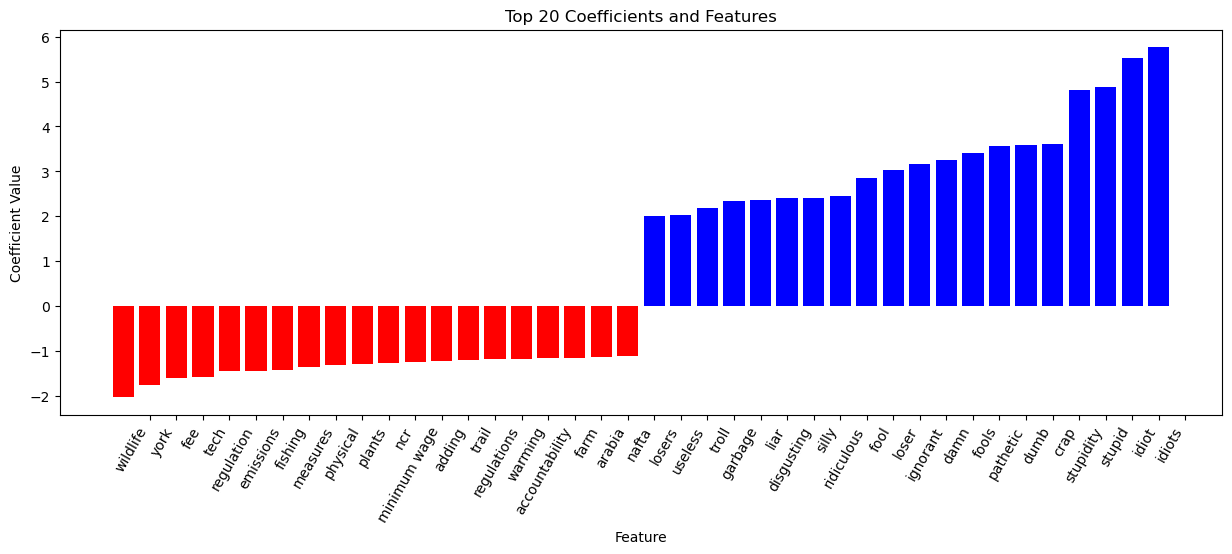

In [168]:
#plot coeffs
ngram_features = vectorizer_ngrams.get_feature_names_out()
plot_coefficients(log_reg2_model, ngram_features)

**Log Reg 3, ngrams excluding unigrams, Identifier: Log_reg3**
- 'lemmatization':False,
- 'stemming':False,
- 'custom_stopwords':None,
- 'include_stopwords':None
- 'n_grams': (2,3)
- 'Vectorization': 'CountVectorizer'

In [178]:
#instantiate count vectorizer
vectorizer_bitri_grams = CountVectorizer(tokenizer= lambda x:my_tokenizer(x,**tokenizer_params_default),
                                             max_features =3000,
                                             min_df =10,
                                             ngram_range =(2,3)
                                            )

In [179]:
#fit and transform X_train, use .fit_transform() method
start_time = time.time()  #start timer

X_train_transformed_2 = vectorizer_bitri_grams.fit_transform(X_train)

end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 


/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vectorization took 61.09 seconds


In [180]:
start_time = time.time()  #start timer

X_test_transformed_2 = vectorizer_bitri_grams.transform(X_test)

end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 


Vectorization took 6.65 seconds


In [187]:
#Log Reg, use baseline pipeline, and same param grid 
scoring_metric = 'F1 Score'
results_logreg3= run_grid_search(X_train_transformed_2, y_train_log, param_grid_log, pipeline_log_base, 
                                 scoring_metric, 'Log_reg3', n_grams='(2,3)', vectorization= 'CountVectorizer', 
                                 tokenizer_params= 'default')

Best Parameters for Log_reg3: {'lr__C': 10}
Best F1 Score Score for Log_reg3: 0.01962361648497664
Accuracy for Log_reg3: 0.9415907219438892
Elapsed Time for Log_reg3: 10.624085187911987 seconds


In [182]:
#predict and evaluate model
log_reg3_model = results_logreg3.best_estimator_
evaluate_model(log_reg3_model, X_test_transformed_2, y_test_log)

Accuracy: 0.9418105219893136
Precision: 0.4396551724137931
Recall: 0.009028146574614976
F1 Score: 0.017692974848222028


(0.9418105219893136,
 0.4396551724137931,
 0.009028146574614976,
 0.017692974848222028)

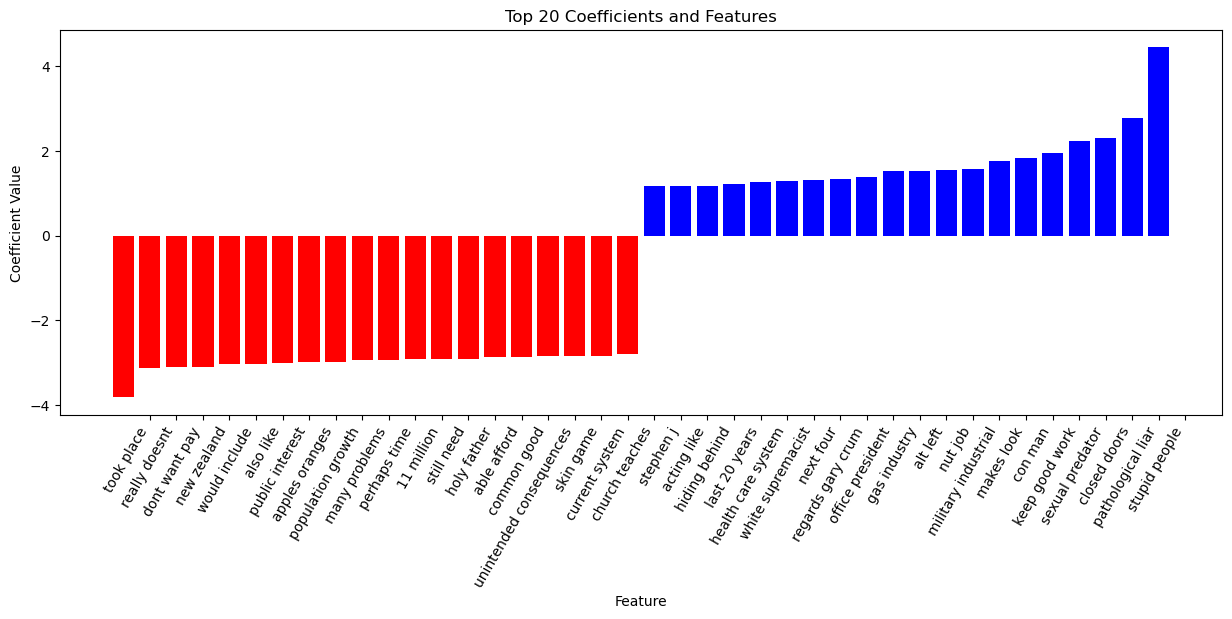

In [183]:
ngram_features_2 = vectorizer_bitri_grams.get_feature_names_out()
plot_coefficients(log_reg3_model, ngram_features_2)

Overall, these metrics indicate that while the model has a high accuracy, it performs poorly in terms of precision, recall, and F1 score. This suggests that the model may be biased towards predicting non-toxic comments and is not effective at correctly identifying toxic comments.

**N-grams Summary** 
Based on the analysis thus far uni and bi grams show about the same model performance. Uni-grmas appear to have the most predictive power as to the likeliehood of the comment being toxic. Bi and tri grams show the worse logistic regression model performance. 

**Summary of Logistic Regression**

| Identifier | Accuracy | Precision | Recall | F1 Score |
|------------|----------|-----------|--------|----------|
| Log_Reg1   | 0.953    | 0.711     | 0.321  | 0.443    |
| Log_Reg2   | 0.953    | 0.715     | 0.318  | 0.440    |
| Log_Reg3   | 0.942    | 0.440     | 0.009  | 0.018    |


## Vectorization of Text: TF-IDF 

TF-IDF Vectorization will be used. Different parameters for TF-IDF vectorization will be set and then logistic regression with base pipeline performed. 

In [193]:
from sklearn.feature_extraction.text import TfidfVectorizer

**Logistic Regression with TF-IDF, Identifier: TF_log_reg1**
- no max_feature param
- ngram_range (unigrams and bigrams)
- min_df,10

In [194]:
tfidf_vectorizer1 = TfidfVectorizer(tokenizer= lambda x:my_tokenizer(x,**tokenizer_params_default),
                                             min_df =10,
                                             ngram_range=(1,2)
                                            )

In [195]:
#fit and transform X_train, use .fit_transform() method
start_time = time.time()  #start timer

X_train_transformed_tf1 = tfidf_vectorizer1.fit_transform(X_train)

end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 

/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vectorization took 27.70 seconds


In [196]:
start_time = time.time()  #start timer

X_test_transformed_tf1 = tfidf_vectorizer1.transform(X_test)

end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 


Vectorization took 6.44 seconds


In [199]:
#Log Reg, use baseline pipeline, and same param grid 
scoring_metric = 'F1 Score'
results_TF_log_reg1 = run_grid_search(X_train_transformed_tf1, y_train_log, param_grid_log, pipeline_log_base, 
                                 scoring_metric, 'TF_log_reg1', n_grams='(1,2)', max_features='None', vectorization= 'TFIDF', 
                                 tokenizer_params= 'default')

Best Parameters for TF_log_reg1: {'lr__C': 10}
Best F1 Score Score for TF_log_reg1: 0.5012413434825838
Accuracy for TF_log_reg1: 0.9795219571973971
Elapsed Time for TF_log_reg1: 47.15357494354248 seconds


In [200]:
#predict and evaluate model
tf_logreg1_model = results_TF_log_reg1.best_estimator_
evaluate_model(tf_logreg1_model, X_test_transformed_tf1, y_test_log)

Accuracy: 0.9605014385532264
Precision: 0.7564649048025007
Recall: 0.4712338466985307
F1 Score: 0.580715532286213


(0.9605014385532264, 0.7564649048025007, 0.4712338466985307, 0.580715532286213)

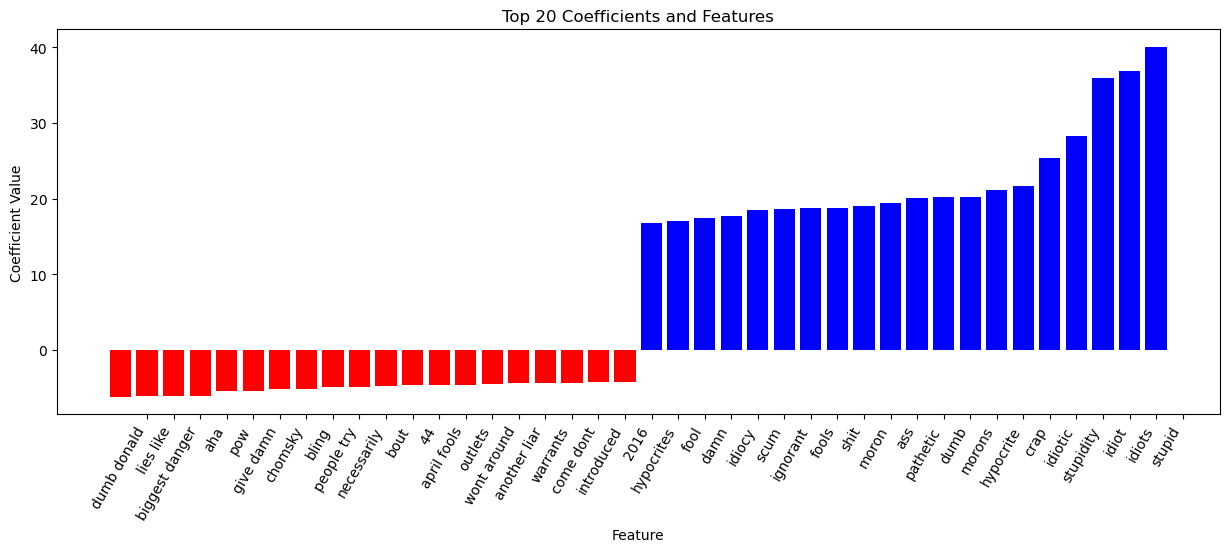

In [201]:
tf1_feature_names = tfidf_vectorizer1.get_feature_names_out()
plot_coefficients(tf_logreg1_model,tf1_feature_names )

**Logistic Regression with TF-IDF, Identifier: TF_log_reg2**
- no max_feature param
- ngram_range (bigrams and trigrams)
- min_df,10

In [202]:
tfidf_vectorizer2 = TfidfVectorizer(tokenizer= lambda x:my_tokenizer(x,**tokenizer_params_default),
                                             min_df =10,
                                             ngram_range=(2,3)
                                            )

In [203]:
#fit and transform X_train, use .fit_transform() method
start_time = time.time()  #start timer

X_train_transformed_tf2 = tfidf_vectorizer2.fit_transform(X_train)

end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 

/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vectorization took 35.74 seconds


In [204]:
start_time = time.time()  #start timer

X_test_transformed_tf2 = tfidf_vectorizer2.transform(X_test)

end_time = time.time()  #end timer
elapsed_time = end_time - start_time
print(f"Vectorization took {elapsed_time:.2f} seconds") 


Vectorization took 7.05 seconds


In [205]:
#Log Reg, use baseline pipeline, and same param grid 
scoring_metric = 'F1 Score'
results_TF_log_reg2 = run_grid_search(X_train_transformed_tf2, y_train_log, param_grid_log, pipeline_log_base, 
                                 scoring_metric, 'TF_log_reg2', n_grams='(2,3)', max_features='None', vectorization= 'TFIDF', 
                                 tokenizer_params= 'default')

Best Parameters for TF_log_reg2: {'lr__C': 10}
Best F1 Score Score for TF_log_reg2: 0.16680730801804763
Accuracy for TF_log_reg2: 0.9565236678597867
Elapsed Time for TF_log_reg2: 26.430095911026 seconds


In [207]:
#predict and evaluate model
tf_logreg2_model = results_TF_log_reg2.best_estimator_
evaluate_model(tf_logreg2_model, X_test_transformed_tf2, y_test_log)

Accuracy: 0.9417694204685574
Precision: 0.4932228915662651
Recall: 0.11594972561515313
F1 Score: 0.1877597821413215


(0.9417694204685574,
 0.4932228915662651,
 0.11594972561515313,
 0.1877597821413215)

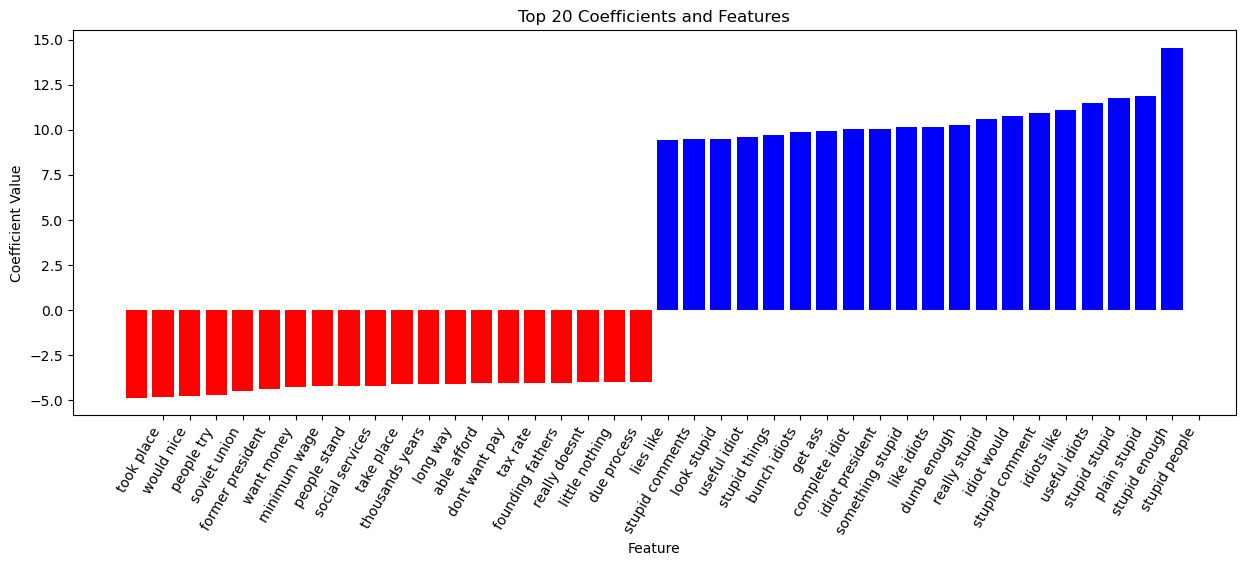

In [208]:
tf2_feature_names = tfidf_vectorizer2.get_feature_names_out()
plot_coefficients(tf_logreg2_model,tf2_feature_names )

**Summary TF-IDF**

It appears that vectorizing the text with TF-IDF with no limit on max features produces better results for logistic regression, in terms of F1 score,  with this sample size. Using ngrams up to trigrams decreases the model performance in terms of F1 score slightly. It appears that features with positive coefficients indicating the likeliehood of a comment being toxic are mostly adjectives, while the features with negative coefficientes indicating the decreased likeliehood of a comment being toxic are mostly relating to topics.  

# Summary

In Summary thusfar, a base linear regression has been done to predict the target; the fraction of annotators that labeled the comment as toxic, as a float. The linear regression did not capture the relationships between the text and toxicity rating well, with a mse of 0.036, mae of 0.136 and R squared of 0.044. The R squared suggests that the model is only explaining 4.49% of the variance in the target varible. The text was processed with a Count Vectorizer for the linear regression. A base logistic regression has also been done, with multiple iterations involving different text processing methods. The best results in terms of F1 score, which takes precision and recall into account were obtained from TF_log_reg1 model, with an F1 score of 0.58. Accuracy for all models was fairly high with accuracy greater than 93% for all models, however due to the large class imbalance in target these accuracy scores do not fully represent the true performance of the model, especially in terms of its ability to correctly predict the minority class.

In [210]:
results_ln_log_df = pd.DataFrame(results_list)

In [211]:
results_ln_log_df

,identifier,best_params,best_score,elapsed_time,n_grams,vectorization,tokenizer_params,max_features
0,Log_Reg1,{'lr__C': 10},0.404825,14.170440,None,None,default,NaN
1,Log_Reg1,{'lr__C': 10},0.404825,12.192642,None,None,default,NaN
2,Log_Reg2,{'lr__C': 10},0.401248,19.358354,"(1,2)",CountVectorizer,default,NaN
3,Log_reg3,{'lr__C': 10},0.401248,19.261597,"(2,3)",CountVectorizer,default,NaN
4,Log_reg3,{'lr__C': 10},0.019624,11.478168,"(2,3)",CountVectorizer,default,NaN
5,Log_Reg1,{'lr__C': 10},0.404825,13.526553,None,CountVectorizer,default,NaN
6,Log_Reg2,{'lr__C': 10},0.401248,18.110751,"(1,2)",CountVectorizer,default,NaN
7,Log_reg3,{'lr__C': 10},0.019624,10.624085,"(2,3)",CountVectorizer,default,NaN
8,TF_log_reg1,{'lr__C': 10},0.501241,47.153575,"(1,2)",TFIDF,default,None
9,TF_log_reg2,{'lr__C': 10},0.166807,26.430096,"(2,3)",TFIDF,default,None


In [213]:
results_ln_log_df.to_csv('baseline_results.csv', index=True)

### Next Steps
Moving forward, taking a larger sample size of the data set will be explored as vectorization of text was not so computationally expensive. It appears that TF-IDF with uni and bigrams was more successful with logistic regression in terms of F1 score. With this, TF-IDF vectorization of entire corpus may be explored, with LSA to reduce dimensionality. A strategy to deal with class imbalance will also be developed such as class weights and models that are able to capture non linear relationships will be explored and compared to baseline model(s)